# Phenomenological model for polygon subsidence

In [1]:
from matplotlib import pyplot as plt
import matplotlib
import scipy.signal
import sys, os
import numpy as np
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)


In [2]:
# topographic points taken from Vladimir NGEE data
x = [0,1.5,2,3,6.5,12.5]
z = [4.9, 5.2, 5.3,5.28, 5.2, 5.0]
x1 = x[:3]
x2 =x[2:]
z1 = z[:3]
z2 =z[2:]
print (x1,x2)
print (z1,z2)
l_x2 = len(x2) -1

[0, 1.5, 2] [2, 3, 6.5, 12.5]
[4.9, 5.2, 5.3] [5.3, 5.28, 5.2, 5.0]


In [3]:
integT = scipy.integrate.trapz(z-np.min(z), x=x)#, even='avg')
print (integT/x[-1])

0.25439999999999974


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


0.29999999999999893 5.3 5.000000000000001


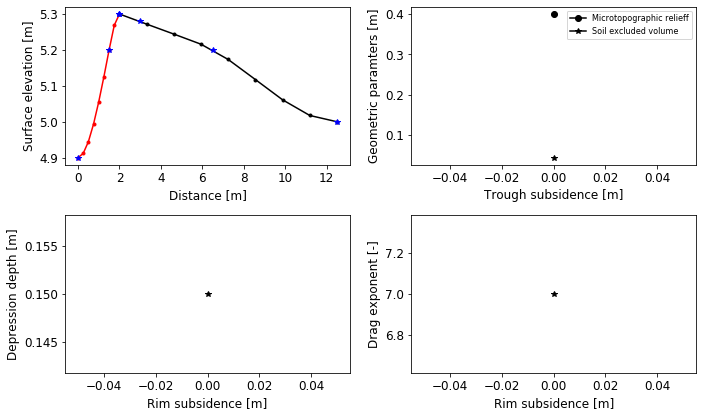

In [4]:
collapse = 0.02
factor = 2.
delta_max = []
delta_ex = []
thaw_depth = []
delta_d = []
delta_c = []
beta = []

fig, ax = plt.subplots(2, 2, figsize=(10,6),facecolor='w',edgecolor='k',gridspec_kw={'width_ratios':[1,1]})
fig.subplots_adjust(hspace=0.2,wspace=1.2)
ax = ax.ravel()
#fig.tight_layout()
for i in range(0,1,1):

    if i > 0:
        Z1 = [z1[0] - i*collapse, z1[1] - i*collapse/(factor-0.), z1[2]- i*collapse/(factor-0)]
        Z2 = [z2[0] - i*collapse/(factor-0), z2[1] - i*collapse/(factor+.5), z2[2]]
    else:
        Z1 = z1
        Z2 = z2
    if Z2[1] <= Z2[2]:
        Z2[2] = Z2[1]
    cs1 = scipy.interpolate.CubicSpline(x1,Z1, bc_type='clamped')
    cs2 = scipy.interpolate.CubicSpline(x2,Z2, bc_type='clamped')

    X1 = np.linspace(0,x1[-1],9)
    X2 = np.linspace(x1[-1],x2[-1],9)
    
    
    ax[0].plot(X1, cs1(X1), '.-', color= 'r', label = 'fitted curve')
    ax[0].plot(X2, cs2(X2), '.-', color= 'k')
    ax[0].plot(x1, Z1, '*', color= 'b', label='measured data')
    ax[0].plot(x2, Z2, '*', color= 'b', label='measured data')
    
    XX1 = np.linspace(X1[0],X1[-1],100000)
    XX2 = np.linspace(X2[0],X2[-1],100000)
    integ1 = scipy.integrate.trapz(cs1(XX1)-np.min(cs1(XX1)), x=XX1)#, even='avg')
    integ2 = scipy.integrate.trapz(cs2(XX2)-np.min(cs2(XX2)), x=XX2)#, even='avg')
    
    del_max = round(cs1(X1)[-1] - cs1(X1)[0],4)
    #print (integ1, integ2)
    total = scipy.integrate.cumtrapz(np.concatenate((cs1(XX1),cs2(XX2))), x=np.concatenate((XX1,XX2)),initial=0)
    #print (del_max, (integ1 + integ1) /16.0)
    delta_max.append(del_max)
    delta_ex.append((integ1 + integ1) /16.0)
    thaw_depth.append((z[0] - cs1(XX1)[0]))
    
    #t1 = 0.15 - (z1[-1] - cs1(XX1)[-1])
    t1 = (cs1(XX1)[-1] - cs2(XX2)[-1]) # delta_c = z_rim - z_c
    print (t1,cs1(XX1)[-1],cs2(XX2)[-1])
    if t1> 0.0:#cs1(XX1)[-1] > cs2(XX2)[-1]:
        m = (0.15 - 0.05)/0.3
        delta_d.append(0.15 - m*(0.3 - t1))
        #delta_c.append(0.3 - t1)
        delta_c.append(0.5*(z[0] - cs1(XX1)[0]))
        
        m = (7.0 - 1.0)/0.3
        beta.append(7 - m*(0.3 - t1))
    else:
        delta_d.append(0.05)
        beta.append(1.0)
        #delta_c.append(0.3 - t1)
        delta_c.append(0.5*(z[0] - cs1(XX1)[0]))
                       
    if i == 0:
        ax[1].plot(thaw_depth,delta_max, '-o',label='Microtopographic relieff',color='k')
        ax[1].plot(thaw_depth,delta_ex,'-*',label='Soil excluded volume',color='k')
        ax[2].plot(delta_c,delta_d,'-*',label='delta_d',color='k')
        ax[3].plot(delta_c,beta,'-*',label='drag_coeff',color='k')
    else:
        ax[1].plot(thaw_depth,delta_max, '-o',color='k')
        ax[1].plot(thaw_depth,delta_ex,'-*',color='k')
        ax[2].plot(delta_c,delta_d,'-*',color='k')
        ax[3].plot(delta_c,beta,'-*',color='k')


ax[0].set_ylabel('Surface elevation [m]')
ax[0].set_xlabel('Distance [m]')
ax[1].set_ylabel('Geometric paramters [m]')
ax[1].set_xlabel('Trough subsidence [m]')

ax[2].set_ylabel('Depression depth [m]')
ax[2].set_xlabel('Rim subsidence [m]')

ax[3].set_ylabel('Drag exponent [-]')
ax[3].set_xlabel('Rim subsidence [m]')


ax[1].legend(loc='best',fontsize=8)
fig.tight_layout()
#plt.savefig(u'/Users/ajc/research/PostProcessing/2019/polygon_subsidence_model/dynamic_sg_coarse.pdf',bbox_inches='tight',dpi=100)

In [5]:
from lmfit import Model
from lmfit import Parameters, minimize
from lmfit import Minimizer, Parameters, report_fit
from scipy.optimize import curve_fit
def func(x,a,b,c,d,dmax1,dex1):
    print ((a * dmax1 + b * dex1), (c * dex1 + d * dmax1))
    return  (a * dmax1 + b * dex1) * (x/dmax1) ** 2 + (c * dex1 + d * dmax1) * (x/dmax1) ** 3

def get_function(phi,pd,dmax,dex):
    x = pd
    y = phi
    
    pmodel = Model(func)
    #params = pmodel.make_params(a=2, b=3, c=2, d=-1,dmax1=dmax[-1],dex1=dex[-1])
    params = pmodel.make_params(a=0.01, b=0.005, c=0.15, d=0.075,dmax1=dmax[-1],dex1=dex[-1])
    params['dmax1'].vary = False 
    params['dex1'].vary = False
    params['a'].vary = False
    params['b'].vary = False
    params['c'].vary = False
    params['d'].vary = False
    """
    params['a'].expr = '2*b'
    params['b'].min = 0.005
    params['c'].expr = '2*d'
    params['d'].max = 4.0
    """
    result = pmodel.fit(y, params, x=x)

    print(result.fit_report())

    xnew = np.linspace(x[0], x[-1], 50)
    ynew = result.eval(x=xnew)
    return xnew, ynew,result.best_fit
    

In [14]:
def solid_of_revolution(dat_f, dat_x):
    max1 = np.max(dat_f)
    min1 = np.min(dat_f)
    dat = [np.pi * ((f)**2 - (min1)**2 ) for f in dat_f ]
    integ = scipy.integrate.trapz(dat, x=dat_x)
    area = np.pi * (dat_x[-1]**2)
    
    return round(integ/area,4)

def check_volumetric_ponded_depth(dmax, dex):
    pd = np.linspace(0,0.65,100)
    flag = False
    for p in pd:
        alpha1 = (2*dmax - 3*dex)/(dmax**2)
        alpha2 = (2*dex - dmax)/(dmax**3)
        vol = alpha1 * (p**2) + alpha2*(p)**3
        if (vol < 0):
            print ('Volumetic pd term: ', dmax, dex, vol)
            flag = True
            break
    return flag

def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

def volumetric_depth(dat_f, dat_x,dmax,dex):
    pd = np.linspace(0,0.7,50)
    max1 = np.max(dat_f)
    min1 = np.min(dat_f)
    
    A = dat_x[-1]
    phi = []
    vol = []
    alpha1 = (2*dmax[-1] - 3*dex[-1])/(dmax[-1]**2)
    alpha2 = (3*dex[-1] - dmax[-1])/(dmax[-1]**3)
    
    for p in pd:
        sum1x = 0
        for i in range(len(dat_f)-1):
            dx = dat_x[i+1] - dat_x[i]
            df = (dat_f[i+1] + dat_f[i])/2.
            t1 = p + min1 - df
            if (t1>0):
                sum1x = sum1x + (t1*dx)
        phi.append(round(sum1x/A,4))
        vol.append(alpha1 * (p**2) + alpha2*(p**3))
   
    xnew1, ynew1, best_fit = get_function(phi,pd,dmax,dex)
    print(non_decreasing(phi))
    print(non_decreasing(vol))
    print(non_decreasing(ynew1))
    
    #plt.plot(pd,pd,'k-')
    #plt.plot(pd,phi,'r.')
    #plt.plot(xnew1,ynew1,'g.')


In [15]:
"""
Testing volume of solid of revolution, exact integral is (8 pi)
ny0 = np.linspace(0,4,100)
fy = [np.sqrt(4-k) for k in ny0]
x10 = solid_of_revolution(fy, ny0)
print (x10)
        sum1x = sum1x + (t1*dx)
                T1.append(t1)
                P1.append(dx)
                if i ==0 or i==
        phi.append(round(sum1x/A,4))
        integ = scipy.integrate.trapz(T1, x=P1)
        phi1.append(integ/A)
"""

'\nTesting volume of solid of revolution, exact integral is (8 pi)\nny0 = np.linspace(0,4,100)\nfy = [np.sqrt(4-k) for k in ny0]\nx10 = solid_of_revolution(fy, ny0)\nprint (x10)\n        sum1x = sum1x + (t1*dx)\n                T1.append(t1)\n                P1.append(dx)\n                if i ==0 or i==\n        phi.append(round(sum1x/A,4))\n        integ = scipy.integrate.trapz(T1, x=P1)\n        phi1.append(integ/A)\n'

In [73]:
# For coase plot
collapse = 0.02
factor = 2.
delta_max = []
delta_ex = []
thaw_depth = []
trough_subs = []
delta_d = []
delta_c = []
beta = []
rim_collap = []

fig, ax = plt.subplots(2, 2, figsize=(8,6),facecolor='w',edgecolor='k',gridspec_kw={'width_ratios':[1,1]})
fig.subplots_adjust(hspace=0.2,wspace=1.2)
ax = ax.ravel()
fig.tight_layout()
Z1_ = np.zeros((60,len(x1)))
Z2_ = np.zeros((60,len(x2)))
deform_step = 5
for i in range(0,60,deform_step):
    print (i)
    if i > 0:
        trough_z0 = i*collapse
        center_z0 = 0
        m1 = (center_z0 - trough_z0 )/(x2[l_x2]-x1[0])
        for i1, xz in enumerate(z1):
            lin = xz + m1 * (x2[l_x2] - x1[i1])
            Z1[i1] = lin
            Z1_[i,i1] = lin
        for i1, xz in enumerate(z2):
            lin = xz + m1 * (x2[l_x2] - x2[i1])
            Z2[i1] = lin
            Z2_[i,i1] = lin
    else:
        Z1 = np.array(z1)
        Z2 = np.array(z2)
        Z1_[i,:] = np.array(z1)
        Z2_[i,:] = np.array(z2)
    if (Z2[l_x2-1] >= Z1[-1] and Z2[l_x2] >= Z2[l_x2-1]):
        #print ('HERE1:', Z1[-1], Z2[l_x2])
        
        Z2[l_x2] = Z2[1+1]
        Z2_[i,l_x2] = Z2_[i,l_x2-1] + (Z1_[i-deform_step,l_x2-1] - Z1_[i,l_x2-1])*0.5
        Z2[l_x2] = Z2_[i,l_x2]
        #print ('HERE2: ', Z2[l_x2], Z1_[i-10,l_x2-1], Z1_[i,l_x2-1])

    cs1 = scipy.interpolate.CubicSpline(x1,Z1_[i,:], bc_type='clamped')
    cs2 = scipy.interpolate.CubicSpline(x2,Z2_[i,:], bc_type='clamped')
    
    X1 = np.linspace(x1[0],x1[-1],9)
    X2 = np.linspace(x2[0],x2[-1],9)
    
    
    ax[0].plot(X1, cs1(X1), '.-', color= 'k', label = 'fitted curve')
    ax[0].plot(X2, cs2(X2), '.-', color= 'k')
    ax[0].plot(x1, Z1, '*', color= 'r', label='measured data')
    ax[0].plot(x2, Z2, '*', color= 'r', label='measured data')
    
    XX1 = np.linspace(X1[0],X1[-1],20)
    XX2 = np.linspace(X2[0],X2[-1],20)
    integ1 = scipy.integrate.trapz(cs1(XX1)-np.min(cs1(XX1)), x=XX1)#, even='avg')
    integ2 = scipy.integrate.trapz(cs2(XX2)-np.min(cs1(XX1)), x=XX2)#, even='avg')
    
    max_x1 = np.max(cs1(X1))
    max_x2 = np.max(cs2(X2)) 
    max_t = max_x1 if max_x1 > max_x2 else max_x2
    
    del_max =  round(max_t - np.min(cs1(X1)),4)

    delta_max.append(del_max)
    dat10 = np.concatenate((cs1(XX1),cs2(XX2)))
    
    exx = solid_of_revolution(dat10, dat_x=np.concatenate((XX1,XX2)))
    
    delta_ex.append(exx)
    
    flag1 = check_volumetric_ponded_depth(delta_max[-1], delta_ex[-1])
    if (flag1):
        volumetric_depth(dat10, np.concatenate((XX1,XX2)),delta_max, delta_ex)
        #break

    trough_subs.append((z[0] - cs1(XX1)[0]))
    thaw_depth = trough_subs
    t1 = (cs1(XX1)[-1] - cs2(XX2)[-1]) 
    
    if i ==0:
        max1 = np.max(Z1_[i,:]) if np.max(Z1_[i,:]) > np.max(Z2_[i,:]) else np.max(Z2_[i,:])
        rim_collap.append(max1)
    else:
        max1 = np.max(Z1_[i,:]) if np.max(Z1_[i,:]) > np.max(Z2_[i,:]) else np.max(Z2_[i,:])
        rim_collap.append(max1)
    """
    # if delta_d and drag_exp is frunction of delta_max
    if t1> 0.0:
        m = (0.15 - 0.05)/(0.4-0.1)
        delta_d.append(0.15 - m*(0.3 - t1))
        delta_c.append(0.5*(z[0] - cs1(XX1)[0]))
        
        m = (7.0 - 1.0)/0.3
        beta.append(7 - m*(0.3 - t1))
    else:
        delta_d.append(0.05)
        beta.append(1.0)
        delta_c.append(0.5*(z[0] - cs1(XX1)[0]))
    """
    if t1> 0.0:
        m = (0.15 - 0.05)/(0.3) # 0.3 = initial rim - initial center 
        delta_d.append(0.15 - m*(0.3 - t1))
        delta_c.append(0.5*(z[0] - cs1(XX1)[0]))
        
        m = (7.0 - 1.0)/0.3
        beta.append(7 - m*(0.3 - t1))
    else:
        delta_d.append(0.05)
        beta.append(1.0)
        delta_c.append(0.5*(z[0] - cs1(XX1)[0]))
        
    if i == 0:
        #ax[1].invert_xaxis()
        
        ax[1].plot(thaw_depth,delta_max, '-o',label='Microtopographic relief',color='k')
        ax[1].plot(thaw_depth,delta_ex,'-*',label='Soil excluded volume',color='k')
        #ax[2].plot(delta_max,delta_d,'-*',color='k')
        #ax[3].plot(delta_max,beta,'-*',label='drag_coeff',color='k')
        ax[2].plot(thaw_depth,delta_d,'-*',color='k')
        ax[3].plot(thaw_depth,beta,'-*',color='k')
    else:
        ax[1].plot(thaw_depth,delta_max, '-o',color='k')
        ax[1].plot(thaw_depth,delta_ex,'-*',color='k')
        #ax[2].plot(delta_max,delta_d,'-*',color='k')
        #ax[3].plot(delta_max,beta,'-*',color='k')
        ax[2].plot(thaw_depth,delta_d,'-*',color='k')
        ax[3].plot(thaw_depth,beta,'-*',color='k')
        #ax[3].axhline(7,0,0.05,color='k')

print (np.round(delta_max,3))
print (np.round(delta_ex,3))
print (np.round(delta_d,3))
print (np.round(beta,3))
print (np.round(thaw_depth,3))
#print (delta_ex)
ax[0].set_ylabel('Surface elevation [m]')
ax[0].set_xlabel('Distance [m]')
ax[1].set_ylabel('Geometric paramters [m]')
ax[1].set_xlabel('Trough subsidence [m]')

ax[2].set_ylabel('Depression depth [m]')
#ax[2].set_xlabel('Microtopographic relief [m]')
ax[2].set_xlabel('Trough subsidence [m]')

ax[3].set_ylabel('Drag exponent [-]')
#ax[3].set_xlabel('Microtopographic relief [m]')
ax[3].set_xlabel('Trough subsidence [m]')

ax[1].legend(loc='best',fontsize=8)
fig.tight_layout()
plt.savefig(u'/Users/ajc/Core/PostProcessing/2019/polygon_subsidence_model/dynamic_sg_coarse.pdf',bbox_inches='tight',dpi=400)

0
5
10
15
Volumetic pd term:  0.4588 0.3077 -6.674068592944518e-07
0.0061265 0.080565
0.0061265 0.080565
0.0061265 0.080565
0.0061265 0.080565
0.0061265 0.080565
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 0
    # data points      = 50
    # variables        = 0
    chi-square         = 0.00669427
    reduced chi-square = 1.3389e-04
    Akaike info crit   = -445.926302
    Bayesian info crit = -445.926302
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a:      0.01 (fixed)
    b:      0.005 (fixed)
    c:      0.15 (fixed)
    d:      0.075 (fixed)
    dmax1:  0.4588 (fixed)
    dex1:   0.3077 (fixed)
0.0061265 0.080565
True
True
True
20
Volumetic pd term:  0.5092 0.3426 -1.1855185421318113e-06
0.006805 0.08957999999999999
0.006805 0.08957999999999999
0.006805 0.08957999999999999
0.006805 0.08957999999999999
0.006805 0.08957999999999999
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = l

In [65]:
import h5py
Keys = ['depression_depth.cell.0', 'drag_exponent.cell.0', 'excluded_volume.cell.0', 
         'microtopographic_relief.cell.0', 'polygon_entity']
key = Keys[4]
file='/Users/ajc/FUSE/simulations/production/barrow_watershed/data/sg_parameters/'
d1_A=h5py.File(file + 'sg_para-watershed468_model1.h5','r')
#print(d1_A.keys())
d2_A=d1_A[key]['0'][:]

d1_B=h5py.File(file + 'sg_para-watershed468_1204.h5','r')
d2_B=d1_B[key]['0'][:]

d1_C=h5py.File(file + 'sg_para-watershed468_0716.h5','r')
d2_C=d1_C[key]['0'][:]

%matplotlib qt
plt.plot(d2_A,'r')
plt.plot(d2_B,'k')
plt.plot(d2_C,'g')

KeyError: "Unable to open object (object 'polygon_entity' doesn't exist)"